In [19]:
import os
import SimpleITK as sitk
import pathlib as pathlib
import numpy as np 
import matplotlib.pyplot as plt

'''
Author: Sal Choueib
Student No. : 10188460
Class: CISC881
Description:

    This script will read in two .mhd volumes, the first is the full abdominal CT, the second is the segmented cyst volume.
    It will also read in the corresponding clinical stratifications from an excel file. 
    First it will split the data set into a train and independent test set to later be used in model testing. The split it 
    applied via sci kit learns' train test split function, and is implemented on just the abdominal CT volume. 
    The code will keep track of the patient ID so that the same patients can be extracted from the segmented cyst volumes. 
    Once the split is finished, the script removes the ID's and will run the data through the patch extraction functin
    
    
    in this function, the abdominal CT and the corresponding segmented cyst CT will be read in, and the latter volume
    will be used to find the center of mass for the patch extraction. This will be at the center of mass of the cyst 
    of each slice. Therefore, only slices containing cysts will be extracted. During the patch extraction, intensity
    values of the patches are normalized. he slices are then stacked in a numpy stack and written to disk. 

'''

def normalize(patch):
    max_val = patch.max()
    ct_arr = patch / max_val
    return ct_arr


def make_directory(path):
    try:
        os.mkdir(path)
        
    except FileExistsError:
        print("-----FAILED: "+path+ " Already exists")
    except OSError:
        print("Failed to create directory in: " +path)
    else:
        print("Directory created in: " +path)
        return None
    try:
        os.makedirs(path)
    except FileExistsError:
        print("-----FAILED: "+path+ " Already exists")
    except OSError:
        print("Failed to create directory in: " +path)
    else:
        print("Directory created in: " +path)
        return None
        

def patch_extraction(img_list, seg_list, patch_size,labels,patient_list):
    #patient_list is simply for console output clarity. 
    
    if len(img_list) != len(seg_list):
        print("Image list and segmented list did not correspond: \n")
        print("Length of image list: " + str(len(img_list)) + "\nLength of segmentation list: " +str(len(seg_list)))
        return
    elif patch_size%2 != 0:
        print("Patch size must be even.\nPatch size: " +str(patch_size))
        return
    
    
    label_indx    = 0
    for patient_index in range(len(img_list)):

        #select co-registered volumes for patient x
        
        img_arr = img_list[patient_index]
        seg_arr = seg_list[patient_index]

        slice_list = []
        #create an index of slices that contain the segmented cyst
        #to use for the slice extraction
        for i in range(len(seg_arr)):
            ct_slice = seg_arr[i,:,:]
            max_val  = ct_slice.max()
            if max_val != -1000:
                slice_list.append(i)

        #Use the slice index to extract patches 
        for slice_indx in range(len(slice_list)-1):
            seg_slice = seg_arr[slice_list[slice_indx],:,:]
            img_slice = img_arr[slice_list[slice_indx],:,:]

            row_sum = 0
            col_sum = 0
            count   = 0
            
            # calculate the center of mass of the cyst from the segmented cyst volume
            for row in range(seg_slice.shape[0]):
                for col in range(seg_slice.shape[1]):
                    if seg_slice[row][col] != -1000:
                        row_sum += row
                        col_sum += col
                        count   += 1

            row_center = round(row_sum/count)
            col_center = round(col_sum/count)
            
            print("Patient: " + str(patient_list[patient_index]))
            print("Patient index: " +str(patient_index))
            print("Patient "+str(patient_index)+ ", slice "+str(slice_indx)+":")
            print("Tumor center of mass: ["+str(row_center)+","+str(col_center)+"]")

            row_min = int(row_center-(patch_size/2))
            row_max = int(row_center+(patch_size/2))

            col_min = int(col_center-(patch_size/2))
            col_max = int(col_center+(patch_size/2))
            
            #from the center of mass of the cyst take all the pixels from range 0 to patch_size/2 in all directions. 
            patch   = img_slice[row_min:row_max,col_min:col_max]
            
            if patient_index == 0 and label_indx==0:
                global ct_patches
                global ct_patch_labels
                ct_patches      =  normalize(patch)
                #ct_patches      =  patch
                ct_patch_labels = labels[patient_index]
                label_indx+=1
                print(ct_patch_labels)
                print("Patch Label to labels: " + str(labels[patient_index]))
            else:
                ct_patches      = np.dstack((ct_patches,normalize(patch)))
                ct_patch_labels = np.vstack((ct_patch_labels,labels[patient_index]))
                print("Patch Label to labels: " + str(labels[patient_index]))
            
            print('-------------------------')
    return ct_patches,ct_patch_labels



In [20]:
#Will extract the patient id's from the already split abdominal CTs, and use that 
#to split the segmented CTs exactly. 
def split_data(ct_train,ct_test,seg_cyst_images):
    cyst_train=[]
    cyst_test =[]
    temparr=seg_cyst_images #to be able to remove elements from list as chosen, for comp. efficiency.
    
    for elem in ct_train:
        pid = elem[0]
        arr = elem[1]
        for seg in temparr:
            if seg[0] == pid:
                cyst_train.append(seg)
                temparr.remove(seg)

    for elem in ct_test:
        pid = elem[0]
        arr = elem[1]
        for seg in seg_cyst_images:
            if seg[0] == pid:
                cyst_test.append(seg)
                seg_cyst_images.remove(seg)
        
    return cyst_train,cyst_test


def remove_id(tuple_list):
    no_id_list=[]
    for patient in tuple_list:
        no_id_list.append(patient[1])
    return no_id_list

In [21]:
import os
import SimpleITK as sitk
import pathlib as pathlib
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

#initializations and input paths
patch_size             =  80 #must be even
input_dir_whole_image  = "C:/Users/salch/pancreasCNN/data/resampled_whole_image"
input_dir_seg_panc     = "C:/Users/salch/pancreasCNN/data/resampled_seg_cyst_nn"
input_dir_clinicalData = "C:/Users/salch/Desktop/THESIS/clinicalData.xlsx"

output_dir_ct_patches_train  = "C:/Users/salch/pancreasCNN/data/patch_extraction/train/"
output_dir_ct_patches_test   = "C:/Users/salch/pancreasCNN/data/patch_extraction/test/"


# Loop through the directory containing the CT volumes and convert them to numpy arrays
# and append them to a list. 
def data_access(input_path): 
    # will create a list of numpy arrays representing volumes from input_path
    
    input_Data   = pathlib.Path(input_path)# path to resampled .mhd files 
    patientFiles = [file for file in input_Data.iterdir()] 
    
    image_list   = []
    for volume in patientFiles: 
        if ".mhd" in str(volume):
            pid = str(volume.stem[0:4])
            img     = sitk.ReadImage(str(volume),imageIO = "MetaImageIO")
            img_arr = sitk.GetArrayFromImage(img)
            image_list.append((pid,img_arr))
    
    return image_list
#---------------------------------------------------------------------------------

# Will read in excel file containing clinical data and convert it to panda datafram
# 
def import_excel(path_clinData):
   
    df               = pd.read_excel(path_clinData)
    df               = df[['ipmn_id', 'risk_strat']]
    df['risk_strat'] = df['risk_strat'].map({'High risk': 1, 'Low risk': 0}) #change label from str to binary value
    df               = df.sort_values(by=['ipmn_id']) #sort the list based on 
    
    return df
#---------------------------------------------------------------------------------

#Then will extract just the label data and sort based 
def label_extraction(input_to_clinData):
    
    labels       = import_excel(input_dir_clinicalData)
    patient_list = labels["ipmn_id"] #not for funtional purpose, just for output
    patient_list = np.expand_dims(patient_list,axis=1)
    labels       = labels["risk_strat"]
    labels       = np.expand_dims(labels,axis=1)
    
    return labels, patient_list
#---------------------------------------------------------------------------------
def save_patches_to_disk(ct_patches,ct_patch_labels,output_dir_ct_labels):
    
    np.save(output_dir_ct_labels+"ct_patches.npy",ct_patches)
    np.save(output_dir_ct_labels+"labels.npy",ct_patch_labels)
    return



def main():

    
    whole_images                              = data_access(input_dir_whole_image) #returns array of CT volume
    seg_cyst_images                           = data_access(input_dir_seg_panc)
    labels,patient_list                       = label_extraction(input_dir_clinicalData)
    
    make_directory(output_dir_ct_patches_train)
    make_directory(output_dir_ct_patches_test)


    #split the data
    
    seed = 7
    numpy.random.seed(seed)
    ct_train, ct_test, labels_train, labels_test = train_test_split(whole_images, labels, test_size=0.25,stratify=labels, random_state=seed)
    
    cyst_train,cyst_test = split_data(ct_train,ct_test,seg_cyst_images)
    
    cyst_train = remove_id(cyst_train)
    cyst_test  = remove_id(cyst_test)
    ct_train   = remove_id(ct_train)
    ct_test    = remove_id(ct_test)
    
    #extraxt the patches
    ct_patches_train, ct_patch_labels_train = patch_extraction(ct_train,
                                                                 cyst_train,
                                                                 patch_size,
                                                                 labels_train,
                                                                 patient_list)
    
    ct_patches_test, ct_patch_labels_test = patch_extraction(ct_test,
                                                                 cyst_test,
                                                                 patch_size,
                                                                 labels_train,
                                                                 patient_list)
    # write ptaches to disk
    save_patches_to_disk(
        ct_patches_train,
        ct_patch_labels_train,
        output_dir_ct_patches_train,
    )

    
    save_patches_to_disk(
        ct_patches_test,
        ct_patch_labels_test,
        output_dir_ct_patches_test,
    )
    
    check()
    
main()


-----FAILED: C:/Users/salch/pancreasCNN/data/patch_extraction/train/ Already exists
-----FAILED: C:/Users/salch/pancreasCNN/data/patch_extraction/train/ Already exists
-----FAILED: C:/Users/salch/pancreasCNN/data/patch_extraction/test/ Already exists
-----FAILED: C:/Users/salch/pancreasCNN/data/patch_extraction/test/ Already exists
Patient: [1261]
Patient index: 0
Patient 0, slice 0:
Tumor center of mass: [204,200]
[0]
Patch Label to labels: [0]
-------------------------
Patient: [1261]
Patient index: 0
Patient 0, slice 1:
Tumor center of mass: [204,200]
Patch Label to labels: [0]
-------------------------
Patient: [1261]
Patient index: 0
Patient 0, slice 2:
Tumor center of mass: [204,202]
Patch Label to labels: [0]
-------------------------
Patient: [1261]
Patient index: 0
Patient 0, slice 3:
Tumor center of mass: [203,204]
Patch Label to labels: [0]
-------------------------
Patient: [1261]
Patient index: 0
Patient 0, slice 4:
Tumor center of mass: [204,205]
Patch Label to labels: [0

Patient: [1284]
Patient index: 4
Patient 4, slice 4:
Tumor center of mass: [253,373]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4
Patient 4, slice 5:
Tumor center of mass: [253,372]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4
Patient 4, slice 6:
Tumor center of mass: [253,372]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4
Patient 4, slice 7:
Tumor center of mass: [252,372]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4
Patient 4, slice 8:
Tumor center of mass: [252,373]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4
Patient 4, slice 9:
Tumor center of mass: [252,373]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4
Patient 4, slice 10:
Tumor center of mass: [252,374]
Patch Label to labels: [0]
-------------------------
Patient: [1284]
Patient index: 4


Patient: [1299]
Patient index: 9
Patient 9, slice 11:
Tumor center of mass: [262,261]
Patch Label to labels: [1]
-------------------------
Patient: [1299]
Patient index: 9
Patient 9, slice 12:
Tumor center of mass: [263,261]
Patch Label to labels: [1]
-------------------------
Patient: [1301]
Patient index: 10
Patient 10, slice 0:
Tumor center of mass: [184,248]
Patch Label to labels: [0]
-------------------------
Patient: [1301]
Patient index: 10
Patient 10, slice 1:
Tumor center of mass: [183,248]
Patch Label to labels: [0]
-------------------------
Patient: [1301]
Patient index: 10
Patient 10, slice 2:
Tumor center of mass: [183,249]
Patch Label to labels: [0]
-------------------------
Patient: [1301]
Patient index: 10
Patient 10, slice 3:
Tumor center of mass: [183,251]
Patch Label to labels: [0]
-------------------------
Patient: [1302]
Patient index: 11
Patient 11, slice 0:
Tumor center of mass: [178,226]
Patch Label to labels: [1]
-------------------------
Patient: [1302]
Patien

Patient: [1325]
Patient index: 18
Patient 18, slice 4:
Tumor center of mass: [187,244]
Patch Label to labels: [0]
-------------------------
Patient: [1325]
Patient index: 18
Patient 18, slice 5:
Tumor center of mass: [187,243]
Patch Label to labels: [0]
-------------------------
Patient: [1325]
Patient index: 18
Patient 18, slice 6:
Tumor center of mass: [186,243]
Patch Label to labels: [0]
-------------------------
Patient: [1325]
Patient index: 18
Patient 18, slice 7:
Tumor center of mass: [186,243]
Patch Label to labels: [0]
-------------------------
Patient: [1325]
Patient index: 18
Patient 18, slice 8:
Tumor center of mass: [186,242]
Patch Label to labels: [0]
-------------------------
Patient: [1327]
Patient index: 19
Patient 19, slice 0:
Tumor center of mass: [249,272]
Patch Label to labels: [0]
-------------------------
Patient: [1327]
Patient index: 19
Patient 19, slice 1:
Tumor center of mass: [249,272]
Patch Label to labels: [0]
-------------------------
Patient: [1327]
Pati

Patient: [1340]
Patient index: 25
Patient 25, slice 3:
Tumor center of mass: [190,274]
Patch Label to labels: [1]
-------------------------
Patient: [1340]
Patient index: 25
Patient 25, slice 4:
Tumor center of mass: [189,273]
Patch Label to labels: [1]
-------------------------
Patient: [1340]
Patient index: 25
Patient 25, slice 5:
Tumor center of mass: [188,271]
Patch Label to labels: [1]
-------------------------
Patient: [1340]
Patient index: 25
Patient 25, slice 6:
Tumor center of mass: [190,270]
Patch Label to labels: [1]
-------------------------
Patient: [1340]
Patient index: 25
Patient 25, slice 7:
Tumor center of mass: [192,270]
Patch Label to labels: [1]
-------------------------
Patient: [1340]
Patient index: 25
Patient 25, slice 8:
Tumor center of mass: [193,270]
Patch Label to labels: [1]
-------------------------
Patient: [1342]
Patient index: 26
Patient 26, slice 0:
Tumor center of mass: [216,210]
Patch Label to labels: [0]
-------------------------
Patient: [1342]
Pati

Patient: [1362]
Patient index: 33
Patient 33, slice 2:
Tumor center of mass: [187,300]
Patch Label to labels: [0]
-------------------------
Patient: [1362]
Patient index: 33
Patient 33, slice 3:
Tumor center of mass: [188,300]
Patch Label to labels: [0]
-------------------------
Patient: [1362]
Patient index: 33
Patient 33, slice 4:
Tumor center of mass: [190,303]
Patch Label to labels: [0]
-------------------------
Patient: [1364]
Patient index: 34
Patient 34, slice 0:
Tumor center of mass: [229,270]
Patch Label to labels: [0]
-------------------------
Patient: [1364]
Patient index: 34
Patient 34, slice 1:
Tumor center of mass: [229,271]
Patch Label to labels: [0]
-------------------------
Patient: [1364]
Patient index: 34
Patient 34, slice 2:
Tumor center of mass: [229,272]
Patch Label to labels: [0]
-------------------------
Patient: [1364]
Patient index: 34
Patient 34, slice 3:
Tumor center of mass: [230,272]
Patch Label to labels: [0]
-------------------------
Patient: [1364]
Pati

Patient: [1375]
Patient index: 38
Patient 38, slice 7:
Tumor center of mass: [223,232]
Patch Label to labels: [0]
-------------------------
Patient: [1377]
Patient index: 39
Patient 39, slice 0:
Tumor center of mass: [173,271]
Patch Label to labels: [0]
-------------------------
Patient: [1377]
Patient index: 39
Patient 39, slice 1:
Tumor center of mass: [173,271]
Patch Label to labels: [0]
-------------------------
Patient: [1377]
Patient index: 39
Patient 39, slice 2:
Tumor center of mass: [172,271]
Patch Label to labels: [0]
-------------------------
Patient: [1377]
Patient index: 39
Patient 39, slice 3:
Tumor center of mass: [173,271]
Patch Label to labels: [0]
-------------------------
Patient: [1378]
Patient index: 40
Patient 40, slice 0:
Tumor center of mass: [224,263]
Patch Label to labels: [1]
-------------------------
Patient: [1378]
Patient index: 40
Patient 40, slice 1:
Tumor center of mass: [223,263]
Patch Label to labels: [1]
-------------------------
Patient: [1382]
Pati

Patient: [1387]
Patient index: 45
Patient 45, slice 11:
Tumor center of mass: [233,236]
Patch Label to labels: [1]
-------------------------
Patient: [1387]
Patient index: 45
Patient 45, slice 12:
Tumor center of mass: [232,237]
Patch Label to labels: [1]
-------------------------
Patient: [1387]
Patient index: 45
Patient 45, slice 13:
Tumor center of mass: [232,237]
Patch Label to labels: [1]
-------------------------
Patient: [1388]
Patient index: 46
Patient 46, slice 0:
Tumor center of mass: [257,238]
Patch Label to labels: [1]
-------------------------
Patient: [1388]
Patient index: 46
Patient 46, slice 1:
Tumor center of mass: [258,238]
Patch Label to labels: [1]
-------------------------
Patient: [1388]
Patient index: 46
Patient 46, slice 2:
Tumor center of mass: [260,235]
Patch Label to labels: [1]
-------------------------
Patient: [1388]
Patient index: 46
Patient 46, slice 3:
Tumor center of mass: [261,234]
Patch Label to labels: [1]
-------------------------
Patient: [1388]
P

Patient: [1424]
Patient index: 51
Patient 51, slice 14:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 15:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 16:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 17:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 18:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 19:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 20:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [142

Patient: [1424]
Patient index: 51
Patient 51, slice 73:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 74:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 75:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 76:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 77:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 78:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [1424]
Patient index: 51
Patient 51, slice 79:
Tumor center of mass: [418,418]
Patch Label to labels: [1]
-------------------------
Patient: [142

Patient: [1430]
Patient index: 55
Patient 55, slice 0:
Tumor center of mass: [232,221]
Patch Label to labels: [1]
-------------------------
Patient: [1430]
Patient index: 55
Patient 55, slice 1:
Tumor center of mass: [233,215]
Patch Label to labels: [1]
-------------------------
Patient: [1430]
Patient index: 55
Patient 55, slice 2:
Tumor center of mass: [231,219]
Patch Label to labels: [1]
-------------------------
Patient: [1433]
Patient index: 56
Patient 56, slice 0:
Tumor center of mass: [214,214]
Patch Label to labels: [0]
-------------------------
Patient: [1433]
Patient index: 56
Patient 56, slice 1:
Tumor center of mass: [214,214]
Patch Label to labels: [0]
-------------------------
Patient: [1433]
Patient index: 56
Patient 56, slice 2:
Tumor center of mass: [213,211]
Patch Label to labels: [0]
-------------------------
Patient: [1433]
Patient index: 56
Patient 56, slice 3:
Tumor center of mass: [213,211]
Patch Label to labels: [0]
-------------------------
Patient: [1433]
Pati

Patient: [1445]
Patient index: 61
Patient 61, slice 8:
Tumor center of mass: [189,149]
Patch Label to labels: [0]
-------------------------
Patient: [1445]
Patient index: 61
Patient 61, slice 9:
Tumor center of mass: [188,145]
Patch Label to labels: [0]
-------------------------
Patient: [1445]
Patient index: 61
Patient 61, slice 10:
Tumor center of mass: [188,143]
Patch Label to labels: [0]
-------------------------
Patient: [1445]
Patient index: 61
Patient 61, slice 11:
Tumor center of mass: [186,141]
Patch Label to labels: [0]
-------------------------
Patient: [1445]
Patient index: 61
Patient 61, slice 12:
Tumor center of mass: [184,140]
Patch Label to labels: [0]
-------------------------
Patient: [1445]
Patient index: 61
Patient 61, slice 13:
Tumor center of mass: [183,139]
Patch Label to labels: [0]
-------------------------
Patient: [1446]
Patient index: 62
Patient 62, slice 0:
Tumor center of mass: [179,244]
Patch Label to labels: [0]
-------------------------
Patient: [1446]


Patient: [1470]
Patient index: 69
Patient 69, slice 5:
Tumor center of mass: [213,286]
Patch Label to labels: [0]
-------------------------
Patient: [1470]
Patient index: 69
Patient 69, slice 6:
Tumor center of mass: [213,285]
Patch Label to labels: [0]
-------------------------
Patient: [1470]
Patient index: 69
Patient 69, slice 7:
Tumor center of mass: [213,284]
Patch Label to labels: [0]
-------------------------
Patient: [1470]
Patient index: 69
Patient 69, slice 8:
Tumor center of mass: [213,283]
Patch Label to labels: [0]
-------------------------
Patient: [1470]
Patient index: 69
Patient 69, slice 9:
Tumor center of mass: [212,283]
Patch Label to labels: [0]
-------------------------
Patient: [1470]
Patient index: 69
Patient 69, slice 10:
Tumor center of mass: [212,282]
Patch Label to labels: [0]
-------------------------
Patient: [1470]
Patient index: 69
Patient 69, slice 11:
Tumor center of mass: [209,282]
Patch Label to labels: [0]
-------------------------
Patient: [1471]
Pa

Patient: [1267]
Patient index: 1
Patient 1, slice 3:
Tumor center of mass: [225,268]
Patch Label to labels: [0]
-------------------------
Patient: [1267]
Patient index: 1
Patient 1, slice 4:
Tumor center of mass: [226,267]
Patch Label to labels: [0]
-------------------------
Patient: [1267]
Patient index: 1
Patient 1, slice 5:
Tumor center of mass: [226,267]
Patch Label to labels: [0]
-------------------------
Patient: [1272]
Patient index: 2
Patient 2, slice 0:
Tumor center of mass: [210,223]
Patch Label to labels: [0]
-------------------------
Patient: [1272]
Patient index: 2
Patient 2, slice 1:
Tumor center of mass: [210,223]
Patch Label to labels: [0]
-------------------------
Patient: [1272]
Patient index: 2
Patient 2, slice 2:
Tumor center of mass: [212,221]
Patch Label to labels: [0]
-------------------------
Patient: [1275]
Patient index: 3
Patient 3, slice 0:
Tumor center of mass: [204,306]
Patch Label to labels: [0]
-------------------------
Patient: [1275]
Patient index: 3
P

Patient: [1297]
Patient index: 8
Patient 8, slice 7:
Tumor center of mass: [222,220]
Patch Label to labels: [0]
-------------------------
Patient: [1297]
Patient index: 8
Patient 8, slice 8:
Tumor center of mass: [222,220]
Patch Label to labels: [0]
-------------------------
Patient: [1297]
Patient index: 8
Patient 8, slice 9:
Tumor center of mass: [222,221]
Patch Label to labels: [0]
-------------------------
Patient: [1297]
Patient index: 8
Patient 8, slice 10:
Tumor center of mass: [220,221]
Patch Label to labels: [0]
-------------------------
Patient: [1297]
Patient index: 8
Patient 8, slice 11:
Tumor center of mass: [219,222]
Patch Label to labels: [0]
-------------------------
Patient: [1299]
Patient index: 9
Patient 9, slice 0:
Tumor center of mass: [202,278]
Patch Label to labels: [1]
-------------------------
Patient: [1299]
Patient index: 9
Patient 9, slice 1:
Tumor center of mass: [203,278]
Patch Label to labels: [1]
-------------------------
Patient: [1299]
Patient index: 9

Patient: [1315]
Patient index: 15
Patient 15, slice 1:
Tumor center of mass: [238,331]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Patient index: 15
Patient 15, slice 2:
Tumor center of mass: [236,332]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Patient index: 15
Patient 15, slice 3:
Tumor center of mass: [236,332]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Patient index: 15
Patient 15, slice 4:
Tumor center of mass: [238,337]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Patient index: 15
Patient 15, slice 5:
Tumor center of mass: [238,337]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Patient index: 15
Patient 15, slice 6:
Tumor center of mass: [238,341]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Patient index: 15
Patient 15, slice 7:
Tumor center of mass: [238,341]
Patch Label to labels: [0]
-------------------------
Patient: [1315]
Pati

Patient: [1331]
Patient index: 21
Patient 21, slice 7:
Tumor center of mass: [258,262]
Patch Label to labels: [0]
-------------------------
Patient: [1331]
Patient index: 21
Patient 21, slice 8:
Tumor center of mass: [258,265]
Patch Label to labels: [0]
-------------------------
Patient: [1331]
Patient index: 21
Patient 21, slice 9:
Tumor center of mass: [259,267]
Patch Label to labels: [0]
-------------------------
Patient: [1336]
Patient index: 22
Patient 22, slice 0:
Tumor center of mass: [199,253]
Patch Label to labels: [0]
-------------------------
Patient: [1336]
Patient index: 22
Patient 22, slice 1:
Tumor center of mass: [199,254]
Patch Label to labels: [0]
-------------------------
Patient: [1336]
Patient index: 22
Patient 22, slice 2:
Tumor center of mass: [205,258]
Patch Label to labels: [0]
-------------------------
Patient: [1336]
Patient index: 22
Patient 22, slice 3:
Tumor center of mass: [206,260]
Patch Label to labels: [0]
-------------------------
Patient: [1336]
Pati

In [24]:
def check():
    print("Patch shape (img_dim, img_dim, img_number): ")
    print(ct_patches_train.shape)
    print(ct_patch_labels_train.shape)
    print("\n\nTraining set positive and negative observation balance: ")
    print("Negative observations (low risk)  : " + str(np.count_nonzero(ct_patch_labels_train==0)))
    print("Postive observations  (high risk) : " + str(ct_patches_train.shape[2]-(np.count_nonzero(ct_patch_labels_train==0))))

    print("\n\nTest set positive and negative observation balance: ")
    print("Negative observations (low risk)  : " + str(np.count_nonzero(ct_patch_labels_test==0)))
    print("Postive observations  (high risk) : " + str(ct_patches_test.shape[2]-(np.count_nonzero(ct_patch_labels_test==0))))

    print('\n\n')
    slics = ct_patches[:,:,156]
    print("Image Dimensions: " + str(slics.shape))
    plt.imshow(slics, cmap='gray')

    print("Label: " + str(ct_patch_labels[156]))
    
    
    #Check the dimensions are correct for the written files

    train = np.load("c:/users/salch/pancreasCNN/data/patch_extraction/train/ct_patches.npy")
    ltrain =np.load("c:/users/salch/pancreasCNN/data/patch_extraction/train/labels.npy")
    print(train.shape)
    print(ltrain.shape)



Image Dimensions: (80, 80)
Label: [0]


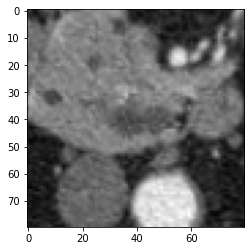

(80, 80, 759)
(759, 1)
